# Sistem Rekomendasi Game dengan Content-Based dan Collaborative Filtering

Proyek ini bertujuan untuk membangun **sistem rekomendasi game** berbasis data pengguna, metadata game, dan interaksi pengguna dengan game. Dua pendekatan yang digunakan adalah:

- **Content-Based Filtering** yaitu memberikan rekomendasi berdasarkan kemiripan antar game berdasarkan fitur.
- **Collaborative Filtering** yaitu memberikan rekomendasi berdasarkan preferensi pengguna lain yang serupa.

Dataset yang digunakan mencakup tiga file utama:
- `recommendations.csv`: Data review game oleh pengguna
- `games.csv`: Data detail game
- `users.csv`: Data pengguna.

sumber data:
https://www.kaggle.com/datasets/antonkozyriev/game-recommendations-on-steam

Nama Lengkap: Muhammad Sulthan Nasyira

Alur Belajar: Machine Learning Engineer

Cohort ID: MC589D5Y2486

Coding Camp Email Username: mc589d5y2486@student.devacademy.id

Email Terdaftar: sulthanasyirah@gmail.com

Group Belajar: MC-49

## 1. Import Library

Pada tahap ini, kita melakukan import library yang diperlukan untuk proses analisis, manipulasi data, dan pembuatan model rekomendasi

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Load Dataset

Kita membaca dataset dari file CSV dan memeriksa informasi awal untuk memahami struktur datanya

In [ ]:
recommendations = pd.read_csv("recommendations.csv")
games = pd.read_csv("games.csv")
users = pd.read_csv("users.csv")

## 3. Data Understanding

## 📊 Data Understanding

Dataset yang digunakan terdiri dari tiga sumber data:

1. `games.csv` berisi informasi game seperti judul, rating, platform, dan tanggal rilis
2. `users.csv` berisi informasi pengguna (user_id)
3. `recommendations.csv` - berisi data rekomendasi pengguna terhadap game, termasuk apakah game direkomendasikan atau tidak.

Langkah awal dilakukan untuk memahami struktur data dan memastikan konsistensi data, termasuk konversi tipe data dan penanganan nilai kosong

In [ ]:
print(recommendations.info())
print(games.info())
print(users.info())

rating_counts = games['rating'].value_counts()

print("Distribusi Rating Game:")
print(rating_counts)

rating_ratio = games.groupby('rating')['positive_ratio'].mean().sort_values(ascending=False)

print("\nRata-rata Positive Ratio per Rating:")
print(rating_ratio)

platform_support = games[['win', 'mac', 'linux', 'steam_deck']].mean() * 100

print("\nPersentase Dukungan Platform:")
print(platform_support.round(2))

recommend_counts = recommendations['is_recommended'].value_counts(normalize=True) * 100

print("\nDistribusi Review Rekomendasi (%):")
print(recommend_counts.round(2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2057740 entries, 0 to 2057739
Data columns (total 9 columns):
 #   Column          Dtype         
---  ------          -----         
 0   app_id          int64         
 1   helpful         int64         
 2   funny           int64         
 3   date            datetime64[ns]
 4   is_recommended  bool          
 5   hours           float64       
 6   user_id         int64         
 7   review_id       int64         
 8   year            int32         
dtypes: bool(1), datetime64[ns](1), float64(1), int32(1), int64(5)
memory usage: 119.7 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2544 entries, 0 to 2543
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   app_id          2544 non-null   int64         
 1   title           2544 non-null   object        
 2   date_release    2544 non-null   datetime64[ns]
 3   win             2544 non-

## 4. Data preparation

- Menggabungkan data rekomendasi dengan data game dan pengguna.
- Menangani nilai kosong pada kolom-kolom penting.
- Mengubah tipe data ke format yang sesuai (`datetime`, `bool`, dll.).
- Menyimpan dataset yang telah dibersihkan ke dalam file `cleaned_recommendations.csv` untuk digunakan dalam proses modelling.


In [ ]:
recommendations['date'] = pd.to_datetime(recommendations['date'])
games['date_release'] = pd.to_datetime(games['date_release'])

games[['win', 'mac', 'linux', 'steam_deck']] = games[['win', 'mac', 'linux', 'steam_deck']].astype(bool)
recommendations['is_recommended'] = recommendations['is_recommended'].astype(bool)

merged_df = recommendations.merge(games, on='app_id', how='left')
merged_df = merged_df.merge(users, on='user_id', how='left')

important_columns = ['title', 'date_release', 'price_final', 'positive_ratio', 'products', 'reviews']
cleaned_df = merged_df.dropna(subset=important_columns)

print(cleaned_df.info())
print(cleaned_df.head())

rows, cols = cleaned_df.shape
print(f"Total rows: {rows}")
print(f"Total columns: {cols}")


<class 'pandas.core.frame.DataFrame'>
Index: 3901 entries, 691 to 2057424
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   app_id          3901 non-null   int64         
 1   helpful         3901 non-null   int64         
 2   funny           3901 non-null   int64         
 3   date            3901 non-null   datetime64[ns]
 4   is_recommended  3901 non-null   bool          
 5   hours           3901 non-null   float64       
 6   user_id         3901 non-null   int64         
 7   review_id       3901 non-null   int64         
 8   year            3901 non-null   int32         
 9   title           3901 non-null   object        
 10  date_release    3901 non-null   datetime64[ns]
 11  win             3901 non-null   object        
 12  mac             3901 non-null   object        
 13  linux           3901 non-null   object        
 14  rating          3901 non-null   object        
 15  posi

In [ ]:
from google.colab import files
cleaned_df.to_csv("cleaned_recommendations.csv", index=False)
files.download("cleaned_recommendations.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 5. Content-Based Filtering

Pendekatan ini merekomendasikan game berdasarkan kesamaan fitur antar game, seperti:

- Rasio ulasan positif (positive_ratio)
- Rating konten (rating)
- Dukungan sistem operasi (Windows, Mac, Linux, Steam Deck)

Fitur dikodekan dan dinormalisasi sebelum dihitung kemiripannya menggunakan *cosine similarity*. Fungsi `recommend_similar_games()` digunakan untuk mengembalikan daftar game yang mirip dengan input.


In [ ]:
content_features = games[['rating', 'positive_ratio', 'win', 'mac', 'linux', 'steam_deck']].copy()

content_features['rating'] = content_features['rating'].fillna("Unknown")
content_features['rating_encoded'] = content_features['rating'].astype('category').cat.codes

feature_matrix = content_features[['rating_encoded', 'positive_ratio', 'win', 'mac', 'linux', 'steam_deck']]
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(feature_matrix)

similarity_matrix = cosine_similarity(scaled_features)

def recommend_similar_games(game_id, top_n=5):
    try:
        idx = games[games['app_id'] == game_id].index[0]
        similarity_scores = list(enumerate(similarity_matrix[idx]))
        similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
        game_indices = [i[0] for i in similarity_scores]
        return games.iloc[game_indices][['app_id', 'title']]
    except:
        return "Game ID not found."

print("\nRekomendasi mirip dengan 'Super Blackjack Battle 2 Turbo Edition - The Card Warriors':")
print(recommend_similar_games(545200))


Rekomendasi mirip dengan 'Super Blackjack Battle 2 Turbo Edition - The Card Warriors':
      app_id                                              title
18   1146320                      GRID Ultimate Edition Upgrade
85   2471820                                    СТРАШНО И ТОЧКА
360  1637251  Train Simulator: Southwestern Expressways: Rea...
409  2169810                                            Mermaid
428   657590                                        Grav Blazer


## 6. Collaborative Filtering

Pendekatan ini menggunakan model **SVD (Singular Value Decomposition)** dari pustaka `Surprise`.

Langkah-langkah:
- Menyusun data dalam format user-item interaction (`user_id`, `app_id`, `is_recommended`)
- Melatih model menggunakan semua data dengan evaluasi RMSE dan MAE melalui cross-validation
- Fungsi `recommend_for_user()` akan memberikan rekomendasi game yang belum pernah diulas oleh pengguna berdasarkan prediksi preferensi.


In [ ]:
cf_data = recommendations[['user_id', 'app_id', 'is_recommended']].copy()
cf_data['is_recommended'] = cf_data['is_recommended'].astype(int)

reader = Reader(rating_scale=(0, 1))
data = Dataset.load_from_df(cf_data[['user_id', 'app_id', 'is_recommended']], reader)

model = SVD()
cross_validate(model, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

trainset = data.build_full_trainset()
model.fit(trainset)

def recommend_for_user(user_id, n=5):
    all_game_ids = games['app_id'].unique()
    reviewed_games = cf_data[cf_data['user_id'] == user_id]['app_id'].values
    unseen_games = [app_id for app_id in all_game_ids if app_id not in reviewed_games]

    if not trainset.knows_user(user_id):
        print(f"User ID {user_id} tidak ditemukan dalam data pelatihan.")
        return pd.DataFrame()

    predictions = [model.predict(user_id, app_id) for app_id in unseen_games]
    top_predictions = sorted(predictions, key=lambda x: x.est, reverse=True)[:n]
    top_app_ids = [pred.iid for pred in top_predictions]
    recommended_games = games[games['app_id'].isin(top_app_ids)][['app_id', 'title']]
    return recommended_games

print("\nRekomendasi game untuk user_id = 253880:")
print(recommend_for_user(253880))


Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.3303  0.3293  0.3289  0.3295  0.0006  
MAE (testset)     0.2136  0.2131  0.2138  0.2135  0.0003  
Fit time          29.40   30.58   30.46   30.14   0.53    
Test time         6.27    3.40    3.52    4.40    1.32    

Rekomendasi game untuk user_id = 253880:
     app_id                                 title
14   402890                           Nyctophilia
21  1845880                  SEARCH ALL - POTIONS
22  1672690  Across the Galaxy: Stellar Dominator
29  1764390                       BAD END THEATER
54  1336950                                VoxFox


##  7. Visualisasi

Untuk membantu interpretasi sistem rekomendasi:

1. Visualisasi game mirip berdasarkan skor kemiripan dengan game tertentu
2. Visualisasi rekomendasi game terbaik untuk pengguna tertentu berdasarkan skor prediksi dari collaborative filtering.

Visualisasi dilakukan menggunakan matplotlib untuk tampilan grafik batang horizontal


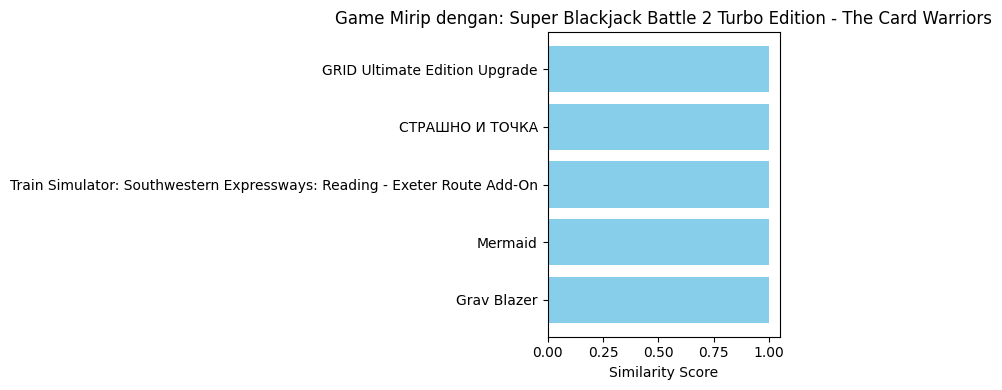

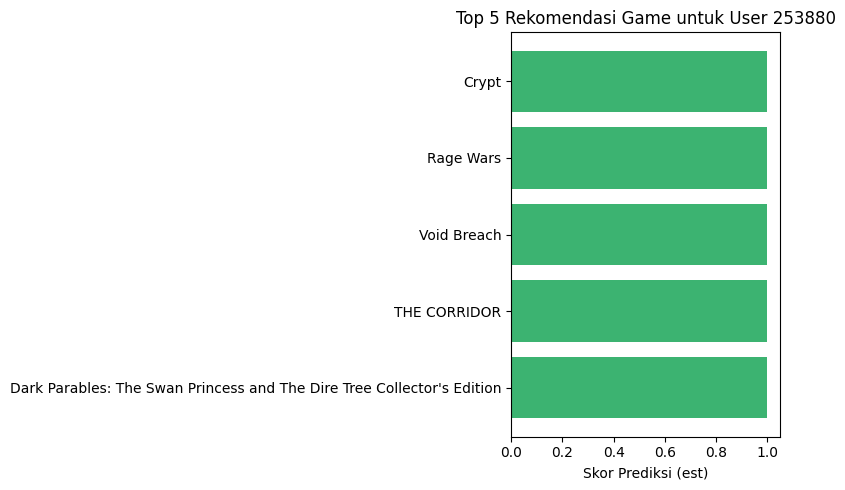

In [ ]:
example_game_id = 545200
example_game_title = games[games['app_id'] == example_game_id]['title'].values[0]

recommended = recommend_similar_games(example_game_id, top_n=5)

idx = games[games['app_id'] == example_game_id].index[0]
similarity_scores = list(enumerate(similarity_matrix[idx]))
similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)[1:6]
scores = [s[1] for s in similarity_scores]
titles = games.iloc[[s[0] for s in similarity_scores]]['title'].values

plt.figure(figsize=(8, 4))
plt.barh(titles[::-1], scores[::-1], color='skyblue')
plt.xlabel('Similarity Score')
plt.title(f'Game Mirip dengan: {example_game_title}')
plt.tight_layout()
plt.show()


def visualize_recommendations(user_id, n=5):

    reviewed_games = cf_data[cf_data['user_id'] == user_id]['app_id'].values
    unseen_games = [app_id for app_id in games['app_id'].unique() if app_id not in reviewed_games]
    predictions = [model.predict(user_id, app_id) for app_id in unseen_games]
    top_predictions = sorted(predictions, key=lambda x: x.est, reverse=True)[:n]

    titles = []
    scores = []
    for pred in top_predictions:
        game_title = games[games['app_id'] == int(pred.iid)]['title'].values[0]
        titles.append(game_title)
        scores.append(pred.est)

    plt.figure(figsize=(8, 5))
    plt.barh(titles[::-1], scores[::-1], color='mediumseagreen')
    plt.xlabel('Skor Prediksi (est)')
    plt.title(f'Top {n} Rekomendasi Game untuk User {user_id}')
    plt.tight_layout()
    plt.show()

visualize_recommendations(253880, n=5)